# Timeseries plot (swimlanes - whatever) of all moorings by location

ToDo: Add following stations

__GOA__
- GPP (2013)
- CS/CSP (2013)

In [22]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter

import cmocean

In [23]:
server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

In [24]:
e = ERDDAP(server=server_url)
# searchterm mooring... subset this later
df = pd.read_csv(e.get_search_url(response='csv', search_for='Mooring'))

In [25]:
from requests.exceptions import HTTPError

dfg = {}
for dataset_id in df['Dataset ID']:
    try:

        e.constraints = None
        e.protocol = 'griddap'

        e.dataset_id=dataset_id
        e.response = 'nc'
        e.variables = ['time']
        ds = e.to_xarray(decode_times=True)
        dfg.update({dataset_id:ds})
    except:
        pass

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'time' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  use_cftime=use_cftime,


In [26]:

dfs = {}
for dataset_id in df['Dataset ID'].values:
    #print(dataset_id)
    try:
        d = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        d.dataset_id=dataset_id
        d.variables = ['latitude','longitude','time']
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))

    try:
        df_m = d.to_pandas(
                    index_col='time (UTC)',
                    parse_dates=True,
                    skiprows=(1,)  # units information can be dropped.
                    )
        df_m.sort_index(inplace=True)
        df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
        
        #-9999 and 1e35 are missing values... but erddap doesn't catch the -9999 yet 
        #and some 1e35 are off a bit
        dfs.update({dataset_id:df_m})
    except:
        pass


In [27]:
# following types of datasets
# preliminary (tabular), final (tabular), final (gridded)
# ADCP (gridded) P moorings only

# BS (bering), CK (chukchi), CB (GOA)
offsets = {'bsm2a':.010,
           'bs2a':.0125,
           'bsp2a':.015,
           'bs2b':.0175,
           'bsp2b':.02,
           'bs2c':.0225,
           'bs4a':.0275,
           'bsp4a':.03,
           'bs5a':.035,
           'bsp5a':.0375,
           'bs5b':.0425,
           'bsp5b':.045,
          'bs8a':.05,
          'bsp8a':.0525,
          'bs8b':.055,
          'bsp8b':.0575,
          'ckip1a':.065,
          'ckp1a':.0675,
          'ckip2a':.0725,
          'ckp2a':.075,          
          'ckip3a':.08,
          'ckp3a':.0825,
          'ckp4a':.0875,
          'ckp5a':.0925,
          'ckp7a':.0975,
          'ckp9a':.1025,
          'ckp10a':.1075,
          'ckp11a':.1125,
          'ckp12a':.1175,
          'ck14a':.1225,
          'cb1a':.13,
          'pa1a':.135,
           'gpp32a':.14,
           'gpp34a':.145,
           'gpp36a':.15,
          }

verbose = True

trying datasets_Mooring_01bs4b_final
FAILED
trying datasets_Mooring_10ckp2a_final
FAILED
trying datasets_Mooring_10ckp3a_final
FAILED
trying datasets_Mooring_11bsc2a_final
FAILED
trying datasets_Mooring_11cb1b_final
FAILED
trying datasets_Mooring_11cbp3a_final
FAILED
trying datasets_Mooring_11cs12a_final
FAILED
trying datasets_Mooring_11cs13a_final
FAILED
trying datasets_Mooring_11csp11a_final
FAILED
trying datasets_Mooring_11ip1a_final
FAILED
trying datasets_Mooring_11kep41a_final
FAILED
trying datasets_Mooring_11pcp1a_final
FAILED
trying datasets_Mooring_11svp39a_final
FAILED
trying datasets_Mooring_12cb1b_final
FAILED
trying datasets_Mooring_12ckip4a_final
FAILED
trying datasets_Mooring_13cs12a_final
FAILED
trying datasets_Mooring_13cs13a_final
FAILED
trying datasets_Mooring_13csp11a_final
FAILED
trying datasets_Mooring_13csp2a_final
FAILED
trying datasets_Mooring_13csp3a_final
FAILED
trying datasets_Mooring_13ipp2a_final
FAILED
trying datasets_Mooring_13kep41a_final
FAILED
trying d

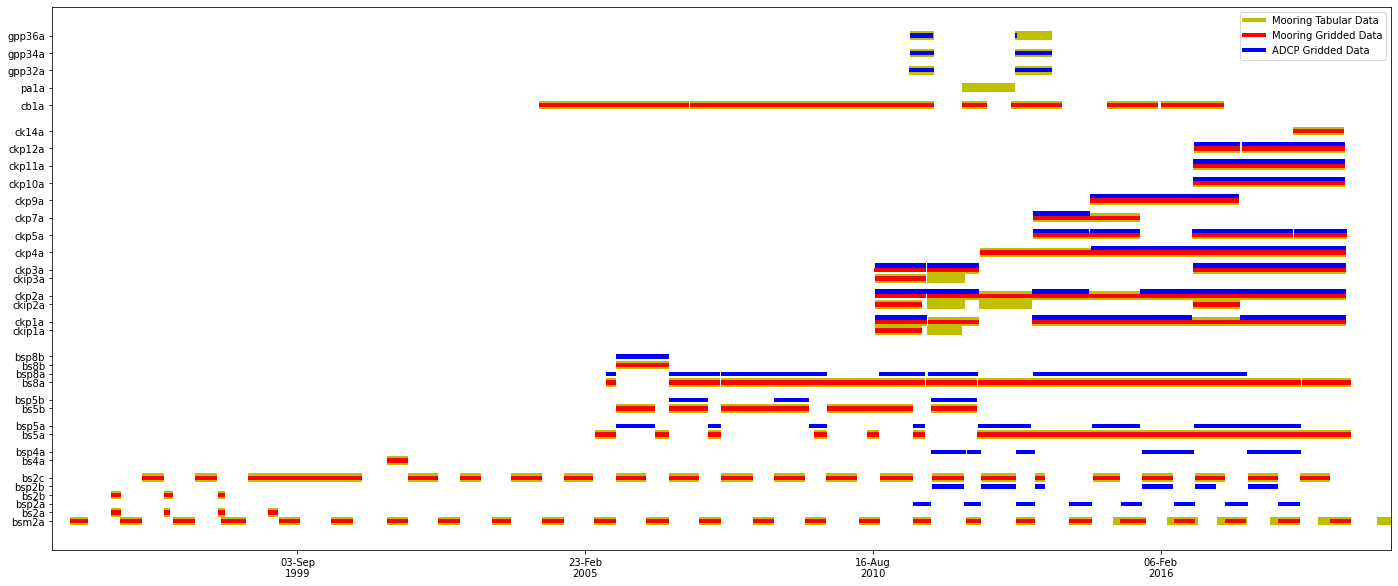

In [28]:
fig = plt.figure(1,figsize=(24,10))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
for dfn, df in dfs.items():
    stage = dfn.split('_')[-1]
    site = dfn.split('_')[-2][2:]
    

    if ('final' in stage) and not ('ADCP' in dfn):
        color='y'
        width=0
    if 'preliminary' in stage:
        color='g'
        width=0
        continue

    try:
        offset = offsets[site]
        duration = (df.last('s').index[0]-df.first('s').index[0]).days

        ax1.barh(offset,duration,width+.0025,left=df.first('s').index[0].to_pydatetime(),
                     color=color,label=dfn) #inital

    except:
        if verbose:
            print(f"trying {dfn}")
            print("FAILED")
        pass

for dfn, df in dfg.items():
    stage = dfn.split('_')[-1]
    site = dfn.split('_')[-2][2:]
    

    if ('ADCP' in dfn):
        color='b'
        width=0
        if 'ck' in dfn:
            offset_c = .00125
        else:
            offset_c = 0

    if '1hr_gridded' in dfn:
        color='r'
        width=0
        offset_c = 0

    try:
        offset = offsets[site] + offset_c
        duration = (datetime.datetime.strptime(dfg[dfn].time_coverage_end,
                           '%Y-%m-%dT%H:%M:%SZ')-datetime.datetime.strptime(dfg[dfn].time_coverage_start,
                           '%Y-%m-%dT%H:%M:%SZ')).days

        ax1.barh(offset,duration,width+.00125,
                 left=datetime.datetime.strptime(dfg[dfn].time_coverage_start,
                                                 '%Y-%m-%dT%H:%M:%SZ'),
                 color=color,label=dfn) #inital

    except:
        if verbose:
            print(f"trying {dfn}")
            print("FAILED")
        pass        
    
plt.yticks(list(offsets.values()), list(offsets.keys()))

xfmt = mdates.DateFormatter('%d-%b\n%Y')
ax1.xaxis.set_major_formatter(xfmt)
ax1.set_xlim([datetime.date(1995,1,1),datetime.date.today()])

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='y', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4)]

ax1.legend(custom_lines, ['Mooring Tabular Data', 'Mooring Gridded Data', 'ADCP Gridded Data'])